# Multi-Label Text Classification with XLNet
基于XLNet的多标签分类问题，原文地址： [https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df](https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df).

在2019年六月发布之后，XLNet在NLP领域的18个任务中获得了SOTA的成就，甚至在20个任务中超过了BERT
XLNet是由CMU和Google Brain联合发布的基于排序的自回归语言模型，已经有很多文章介绍过XLNet的详解，本文主要关注于如何使用XLNet进行多类型、多标签的文本分类。

## Introduction
在文本多分类(multi-class classification)问题中，一般有多个标签，但是每条数据只属于一种类型，然而，在多标签(multi-label)文本分类问题中，一条文本样本可以被赋予多个标签。我们将使用[Transformers](https://github.com/huggingface/transformers)项目来实现，它集成了BERT, XLNet, GPT-2, RoBERTa, CTRL,等诸多模型。<br>
在此鸣谢[Kaushal Trivedi](https://medium.com/@kaushaltrivedi)，他提供了[基于BERT的多标签分类教程](https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d)。<br>
我们将使用Kaggle的[Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview)，需要预测用户的评论属于六种恶意类型(toxic, severetoxic, obscene, threat, insult, identity hate)中的哪一种或几种。
在此说明，XLNet有基础版和完整版两种：
* XLNet Base: 12 layers, 768 hidden units, 12 attention heads, 110M parameters.
* XLNet Large: 24 layers, 768 hidden units, 16 attention heads, 340M parameters  
基于GPU的限制，训练中使用了小型的XLNet。根据迁移学习的概念，我们不会从0开始训练一个模型，而是在预训练的XLNet上进行微调（注：1.原文使用了Google Colab进行训练，这里我使用了公司的机器训练，因此代码上稍微做了修改；2.因为网络原因，我先下载好了预训练的模型，而非执行代码时下载）。

## Code
原文[代码](https://colab.research.google.com/drive/1o3cv-YSPGiKftCvFnCiMcygARqdaxrM7)

首先要安装transformers

In [1]:
# %pip install transformers

导入必要的python模块

In [1]:
import os
import math
import numpy as np
import pandas as pd
import time

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

检查GPU是否可用

In [3]:
print("GPU Available: {}".format(torch.cuda.is_available()))
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    print("Number of GPU Available: {}".format(n_gpu))
    print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 4
GPU: TITAN V


In [4]:
# 将notebook挂在到google drive上，因为我没有使用google drive 因此注释掉
# from google.colab import drive
# drive.mount('/content/drive')

导入数据并查看样本

In [5]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")


In [6]:
train.head(6)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0


In [7]:
label_cols = train.columns[-6:]
train[label_cols].astype("category").describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571,159571,159571,159571,159571,159571
unique,2,2,2,2,2,2
top,0,0,0,0,0,0
freq,144277,157976,151122,159093,151694,158166


让我们做一些快速的EDA。 分析标签的分布，我们注意到标签是不平衡的。

/home/lizhuoxuan/anaconda3/envs/jinghao/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<AxesSubplot:title={'center':'identity_hate'}>,
        <AxesSubplot:title={'center':'insult'}>],
       [<AxesSubplot:title={'center':'obscene'}>,
        <AxesSubplot:title={'center':'severe_toxic'}>],
       [<AxesSubplot:title={'center':'threat'}>,
        <AxesSubplot:title={'center':'toxic'}>]], dtype=object)

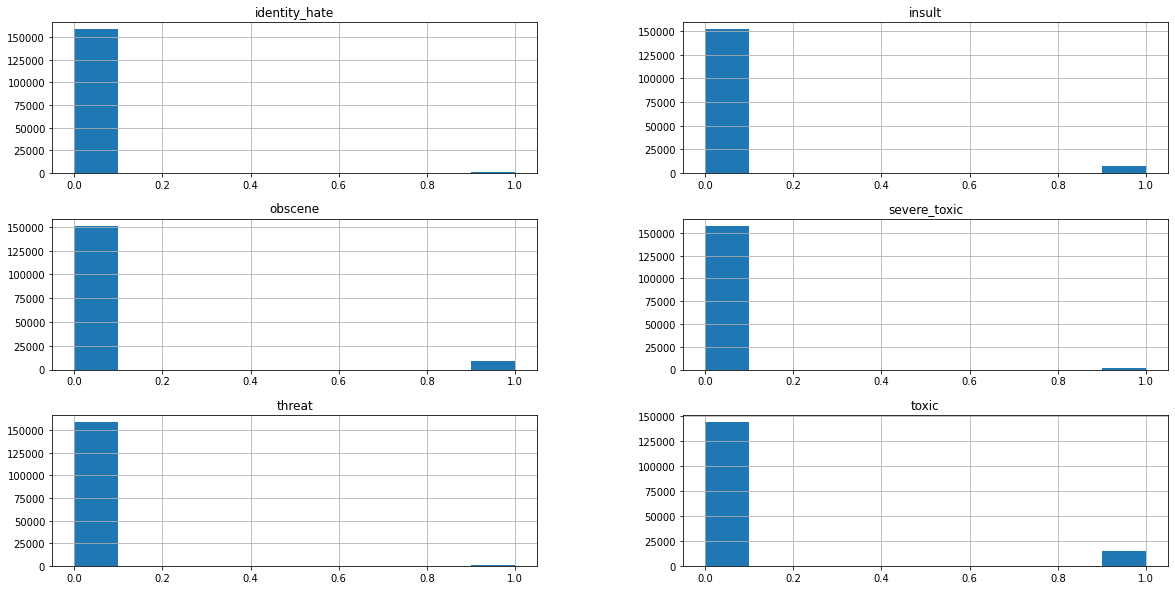

In [8]:
fig, ax = plt.subplots(figsize=(20, 10));
train[label_cols].hist(ax=ax)

在将数据送入模型之前，必须先将文档分词成子单词，我们使用transformers中的XLNetTokenizer功能进行实现。理论上XLNet Base可以处理长度为512的子单词序列，但是受制于GPU规模，以及为了缩短训练时间，我们将使用更短的序列。

我们将分析每条评论包含sub-words个数的分布

In [9]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    # 分词并统计长度
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t:len(t), tokenized_texts))
    # 绘图
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(tokenized_texts_len, bins=40)
    ax.set_xlabel("Length of Comment Embeddings")
    ax.set_ylabel("Number of Comments")
    return

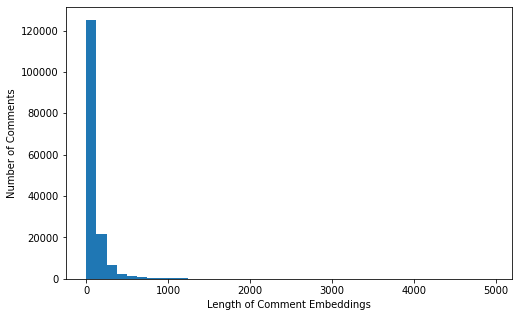

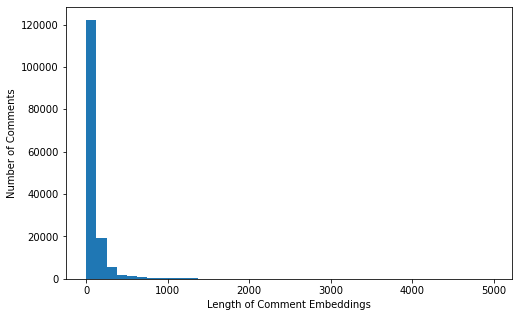

In [10]:
tokenizer = XLNetTokenizer.from_pretrained("model/transformers/xlnet-base-cased/", do_lower_case=True)
train_text_list = train["comment_text"].values
test_text_list = test["comment_text"].values

plot_sentence_embeddings_length(train_text_list, tokenizer)
plot_sentence_embeddings_length(test_text_list, tokenizer)

可以看到大多数文本都词数都少于256，因此设置序列长度为256 
将输入的文本序列转化为合适的数字

In [11]:
def tokenize_inputs(text_list, tokenizer, num_embedding=512):
    """
    将文本转换为数字id，在文段的尾部添加结束标记，然后对文本进行截断或者填充
    """
    # 分词，并且将序列截断，留出两个位置给特殊符号
    tokenized_texts = list(map(lambda x: tokenizer.tokenize(x)[:num_embedding-2], text_list))
    # 将分好的词转换为数字id
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # 添加特殊符号<s>和</s>(开始和结束)到文本中
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequence
    input_ids = pad_sequences(input_ids, maxlen=num_embedding, dtype="long", truncating="post", padding="post")
    return input_ids

In [12]:
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embedding=256)
train_input_ids.shape

(159571, 256)

In [13]:
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embedding=256)

接下来我们将实现注意力机制的masks，这将指导模型关注特定的点。这一步的目的是防止我们的模型关注到padding的部分

In [14]:
def create_attn_masks(input_ids):
    """
    注意力机制，提醒模型该注意到哪些token
    """
    # 构造masks
    attention_masks = []
    # 如果是单词转换成的数字id，mask置1，否则置0
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

将分词后的数字id和注意力masks添加到dataframe中

In [15]:
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [16]:
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,features,masks
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"[6267, 611, 18, 8619, 23, 140, 168, 94, 20413,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[17, 66, 26, 3806, 694, 136, 43, 2466, 52, 300...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"[43, 117, 326, 19, 17, 150, 26, 98, 343, 50, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [17]:
test.head(3)

,id,comment_text,features,masks
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,"[17, 4333, 15683, 17, 1653, 1614, 27, 70, 2718...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"[5847, 5383, 40, 17, 213, 722, 369, 5847, 5383...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...","[17, 12, 5847, 5383, 1675, 5847, 5383, 6940, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


从训练集中划分出一部分数据作为验证集

In [18]:
train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [19]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

y_train = train[label_cols].values.tolist()
y_valid = valid[label_cols].values.tolist()

将特征，mask和标签转化为torch tensor

In [20]:
# 将所有输入和masks,labels转换为torch tensor
X_train_tensor = torch.tensor(X_train)
X_valid_tensor = torch.tensor(X_valid)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)

train_masks_tensor = torch.tensor(train_masks, dtype=torch.long)
valid_masks_tensor = torch.tensor(valid_masks, dtype=torch.long)

接下来为训练集和验证集构造`DataLoaders`，我们使用大小为32的batch。(如果GPU显存不足，则考虑更小的batch_size)

In [21]:
# 使用DataLoader构造数据迭代器，能够节约内存
# 因为迭代器不需要将数据一次加载到内存中，这点和for循环不同
BATCH_SIZE = 20

train_data = TensorDataset(X_train_tensor, train_masks_tensor, y_train_tensor)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(X_valid_tensor, valid_masks_tensor, y_valid_tensor)
valid_sampler = RandomSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

接下来实现我们的XLNet分类模型

In [22]:
class XLNetMultiLabel(nn.Module):
    def __init__(self, num_labels=2):
        super(XLNetMultiLabel, self).__init__()
        self.num_labels = num_labels  # 总共有几种标签
        self.xlnet = XLNetModel.from_pretrained("model/transformers/xlnet-base-cased/")
        self.classifier = torch.nn.Linear(768, num_labels)
        
        nn.init.xavier_normal_(self.classifier.weight)
        
    def pool_hidden_state(self, last_hidden_state):
        # 将最后一个隐藏层的输出池化到一个单一均值向量中
        last_hidden_state = last_hidden_state[0]
        mean_last_hidden_state = torch.mean(last_hidden_state, 1)
        return mean_last_hidden_state
    
    def set_trainable(self, is_trainable):
        """
        设置是否更新模型参数
        """
        for param in self.xlnet.parameters():
            if is_trainable:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        # 最后一个隐藏层
        last_hidden_state = self.xlnet(input_ids=input_ids, 
                                       attention_mask=attention_mask, 
                                       token_type_ids=token_type_ids,
                                      )
        mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
        logits = self.classifier(mean_last_hidden_state)
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(
                logits.view(-1, self.num_labels),
                labels.view(-1, self.num_labels),
            )
            return loss
        else:
            return logits
        
    def freeze_xlnet_decoder(self):
        """
        Freeze XLNet weight parameters. They will not be updated during training.
        """
        for param in self.xlnet.parameters():
            param.requires_grad = False
    
    def unfreeze_xlnet_decoder(self):
        """
        Unfreeze XLNet weight parameters. They will be updated during training.
        """
        for param in self.xlnet.parameters():
            param.requires_grad = True

In [23]:
model = XLNetMultiLabel(num_labels=len(y_train_tensor[0]))

由于输入的序列长度为256，XLNet将会产生256个输出向量，每个向量的长度为768。因此我们对每个输出向量进行均值池化，然后生成一个维度为768的单一向量，这个向量将用来预测六种恶意评论标签。
<div style="align: center">
    <img src="img/structure.jpeg" width="300" height="300"/>
</div>
也可以使用其他的池化方法，或者将所有输出concatenate到一个大的单一向量中，或者直接使用XLNet的输出(last_hidden_state)。

接下来，我们将初始化优化器，你也可以使用自适应的学习率(learning rate schedule)

In [24]:
def train(model: XLNetMultiLabel, num_epochs, train_dataloader, valid_dataloader, model_save_path, 
          train_loss_set=[], valid_loss_set=[], lowest_eval_loss=None, start_epoch=0,
          device="cpu"):
    """
    训练模型，并在验证集loss最低时保存模型
    """
#     device = torch.device(device)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
    step_count = 0
    for i in trange(num_epochs, desc="Epoch"):
        print(time.asctime())
        # trange 是 tqdm在python range外封装的进度条显示
        
        # 如果是从已经保存的模型中继续训练
        actual_epoch = start_epoch + i
        
        model.train()
        
        tr_loss = 0
        num_train_samples = 0
        
        for step, batch in enumerate(train_dataloader):
            step_count += 1
            # 将batch送入GPU
            batch = tuple(t.to(device) for t in batch)
            # 从dataloader中获得数据(unpack tuple)
            b_inputs_ids, b_input_mask, b_labels = batch
            # 清除梯度
            optimizer.zero_grad()
            # 前向传递
            loss = model(b_inputs_ids, attention_mask=b_input_mask, labels=b_labels)
            tr_loss += loss.item()
            num_train_samples += b_labels.size(0)
            # 反向传播
            loss.backward()
            # 使用计算得到的梯度来更新参数
            optimizer.step()
            if step_count % 1000 == 0:
                print(f"step: {step_count}, loss: {loss}")
        # 更新变量
        epoch_train_loss = tr_loss / num_train_samples
        train_loss_set.append(epoch_train_loss)
        print("Train loss: {}".format(epoch_train_loss))
        
        # Validation
        # 计算模型在验证集上的loss
        model.eval()
        eva_loss = 0
        num_eval_samples = 0
        
        for batch in valid_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_valid_ids, b_valid_mask, b_valid_labels = batch
            # 不计算和存储梯度，以加速计算并节约内存
            with torch.no_grad():
                loss = model(b_valid_ids, attention_mask=b_valid_mask, labels=b_valid_labels)
                eva_loss += loss.item()
                num_eval_samples += b_valid_labels.size(0)
        epoch_eval_loss = eva_loss / num_eval_samples
        valid_loss_set.append(epoch_eval_loss)
        print("Valid loss: {}".format(epoch_eval_loss))
        
        # 保存模型
        if lowest_eval_loss == None:
            lowest_eval_loss = epoch_eval_loss
            save_model(model=model, 
                       save_path=model_save_path, 
                       epochs=actual_epoch,
                       lowest_eval_loss=lowest_eval_loss,
                       train_loss_hist=train_loss_set,
                       valid_loss_hist=valid_loss_set,
                      )
        print("\n")
        return model, train_loss_set, valid_loss_set

In [25]:
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
    """
    Save the model to the path directory provided
    """
    model_to_save = model.module if hasattr(model, 'module') else model
    checkpoint = {'epochs': epochs, 
                  'lowest_eval_loss': lowest_eval_loss, 
                  'state_dict': model_to_save.state_dict(), 
                  'train_loss_hist': train_loss_hist, 
                  'valid_loss_hist': valid_loss_hist
                 }
    torch.save(checkpoint, save_path)
    print("Saving model at epoch {} with validation loss of {}".format(epochs, lowest_eval_loss))

def load_model(save_path):
    """
    Load the model from the path directory provided
    """
    checkpoint = torch.load(save_path)
    model_state_dict = checkpoint['state_dict']
    model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
    model.load_state_dict(model_state_dict)
    
    epochs = checkpoint.get("epochs")
    lowest_eval_loss = checkpoint.get("lowest_eval_loss")
    train_loss_hist = checkpoint.get("train_loss_hist")
    valid_loss_hist = checkpoint.get("valid_loss_hist")
    return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [26]:
num_epochs = 5
cwd = os.getcwd()
model_save_path = "model/transformers/xlnet-comment/mulitlabel.bin"

In [27]:
model, train_loss_set, valid_loss_set = train(model=model,
                                              num_epochs=num_epochs,
                                              train_dataloader=train_dataloader,
                                              valid_dataloader=valid_dataloader,
                                              model_save_path=model_save_path,
                                              device="cuda:2")

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Mon Jul 27 09:37:09 2020
step: 1000, loss: 0.035142313688993454
step: 2000, loss: 0.044857610017061234
step: 3000, loss: 0.07852060347795486
step: 4000, loss: 0.00665649538859725
step: 5000, loss: 0.07515759021043777
step: 6000, loss: 0.052490513771772385
Train loss: 0.002353947195346081
Valid loss: 0.0022566458366870515


Epoch:   0%|          | 0/5 [1:10:00<?, ?it/s]

Saving model at epoch 0 with validation loss of 0.0022566458366870515




模型训练完毕后，就可以对测试集进行预测了。如果我们想一次性预测所有测试样本，那么显存会不足，因此我们需要每次预测batch_size个样本，然后再将结果拼接。

In [28]:
def prediction(model, test_frame, num_labels, device='cpu', batch_size=16):
    num_iter = math.ceil(test_frame.shape[0] / batch_size)  # 计算batch数
    pred_probs = np.array([]).reshape(0, num_labels)
    model.to(device)
    model.eval()
    
    for i in range(num_iter):
        test_batch = test_frame.iloc[i*batch_size:(i+1)*batch_size, :]
        X = test_batch["features"].values.tolist()
        masks = test_batch["masks"].values.tolist()
        X = torch.tensor(X)
        masks = torch.tensor(X, dtype=torch.long)
        
        X = X.to(device)
        masks = masks.to(device)
        
        with torch.no_grad():
            logits = model.forward(input_ids=X, attention_mask=masks)
            logits = logits.sigmoid().detach().cpu().numpy()
            pred_probs = np.vstack([pred_probs, logits])
    return pred_probs

In [29]:
num_labels = len(label_cols)
pred_probs = prediction(model, test, num_labels, device="cuda:2", batch_size=16)

/home/lizhuoxuan/anaconda3/envs/jinghao/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [32]:
np.round(pred_probs)

array([[1., 1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0.]])

In [34]:
test.head()

,id,comment_text,features,masks
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,"[17, 4333, 15683, 17, 1653, 1614, 27, 70, 2718...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"[5847, 5383, 40, 17, 213, 722, 369, 5847, 5383...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...","[17, 12, 5847, 5383, 1675, 5847, 5383, 6940, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,00017563c3f7919a,":If you have a look back at the source, the in...","[17, 60, 1963, 44, 47, 24, 338, 126, 38, 18, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,00017695ad8997eb,I don't anonymously edit articles at all.,"[17, 150, 220, 26, 46, 9502, 111, 8619, 2883, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [35]:
test.iloc[0].comment_text

"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"

In [36]:
test_labels = pd.read_csv("data/test_labels.csv")

In [48]:
test_labels[label_cols] = pred_probs

In [49]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998909,0.517510,0.989272,0.011983,0.954833,0.403485
1,0000247867823ef7,0.001156,0.000006,0.000091,0.000014,0.000017,0.000015
2,00013b17ad220c46,0.000929,0.000006,0.000081,0.000011,0.000018,0.000014
3,00017563c3f7919a,0.000407,0.000003,0.000044,0.000005,0.000007,0.000005
4,00017695ad8997eb,0.003561,0.000012,0.000194,0.000034,0.000062,0.000026


In [51]:
test_labels.to_csv("rst.csv", index=False, encoding="utf-8-sig")